In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Experiment


In [ ]:
# 二叉树编码
def binary_tree_encode(xi, U, depth):
    vector = np.zeros(2 ** depth)
    l, r = 0, U
    idx = 0
    for _ in range(depth):
        m = (l + r) // 2
        if xi <= m:
            r = m
            idx = idx * 2
        else:
            l = m + 1
            idx = idx * 2 + 1
    vector[idx] = 1
    return vector

# 扰动 bit vector：randomized response
def perturb(vector, epsilon):
    """
    向量化 Randomized Response 机制，加快扰动速度
    """
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    rand_vals = np.random.rand(len(vector))
    flip_mask = rand_vals > p
    return np.abs(vector - flip_mask.astype(int))


# Local DP 总和估计主函数
def local_dp_sum_estimation(data, U, epsilon, depth):
    n = len(data)
    d = 2 ** depth
    encoded_vectors = []

    for xi in data:
        enc = binary_tree_encode(xi, U, depth)
        noisy = perturb(enc, epsilon)
        encoded_vectors.append(noisy)

    agg = np.sum(encoded_vectors, axis=0)

    # 逆推期望值
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    est_bits = (agg - n * q) / (p - q)

    # 简化求估计值
    avg_leaf = np.dot(est_bits, np.arange(d)) / n
    est_sum = avg_leaf * n * U / d
    return est_sum

# Laplace机制
def laplace_mechanism(data, U, epsilon):
    true_sum = np.sum(data)
    noise = np.random.laplace(scale=U / epsilon)
    return true_sum + noise

# 多组实验（误差对比）
def run_experiments(U=100, trials=30):
    ns = [100, 500, 1000]
    epsilons = [0.5, 1.0, 2.0]
    depths = [4, 5, 6]

    results = []

    for n in ns:
        for epsilon in epsilons:
            for depth in depths:
                ldp_errors = []
                laplace_errors = []

                for _ in range(trials):
                    data = np.random.randint(0, U + 1, size=n)
                    true_sum = np.sum(data)

                    ldp_est = local_dp_sum_estimation(data, U, epsilon, depth)
                    laplace_est = laplace_mechanism(data, U, epsilon)

                    ldp_errors.append(abs(ldp_est - true_sum))
                    laplace_errors.append(abs(laplace_est - true_sum))

                results.append({
                    'n': n,
                    'epsilon': epsilon,
                    'depth': depth,
                    'ldp_mean_error': np.mean(ldp_errors),
                    'laplace_mean_error': np.mean(laplace_errors)
                })

    return pd.DataFrame(results)

In [ ]:
# 模拟数据
np.random.seed(0)
data = np.random.randint(0, 100, size=500)  # 每个用户值在[0, 100]
U = 100
epsilon = 1.0
depth = 5  # 控制bit vector长度为32

est = local_dp_sum_estimation(data, U, epsilon, depth)
true_sum = np.sum(data)

print(f"True Sum: {true_sum}")
print(f"Estimated Sum (LDP): {est:.2f}")

True Sum: 24355
Estimated Sum (LDP): 15590.79


In [ ]:
# 运行实验并保存结果
results_df = run_experiments()
results_df.to_csv("ldp_vs_laplace_error_results.csv", index=False)
print(results_df.head())

     n  epsilon  depth  ldp_mean_error  laplace_mean_error
0  100      0.5      4     3209.448791          183.520316
1  100      0.5      5     4820.413666          203.359462
2  100      0.5      6     7625.464291          154.779424
3  100      1.0      4     2020.237304           93.322761
4  100      1.0      5     1916.243292          101.108799


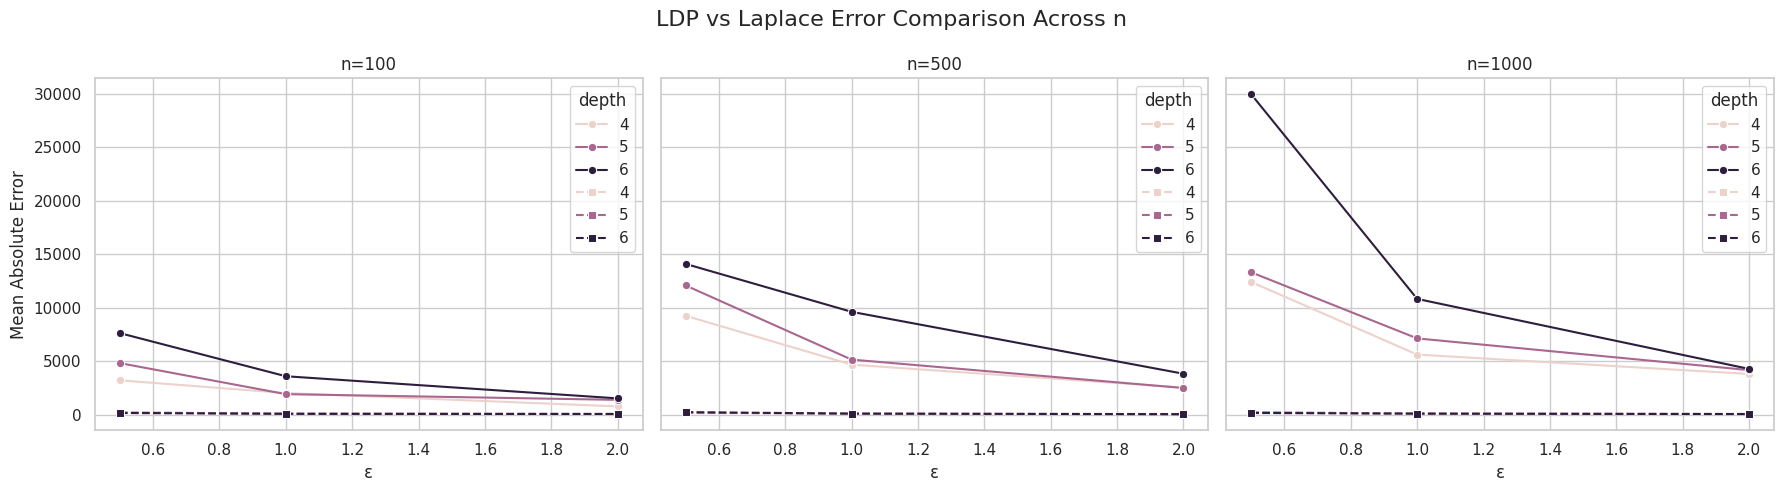

In [ ]:
def plot_multiple_n(df):
    ns = sorted(df['n'].unique())
    fig, axs = plt.subplots(1, len(ns), figsize=(18,5), sharey=True)

    for i, n in enumerate(ns):
        subset = df[df['n'] == n]
        ax = axs[i]
        sns.lineplot(data=subset, x="epsilon", y="ldp_mean_error", hue="depth", marker='o', ax=ax)
        sns.lineplot(data=subset, x="epsilon", y="laplace_mean_error", hue="depth", marker='s', linestyle='--', ax=ax)
        ax.set_title(f"n={n}")
        ax.set_ylabel("Mean Absolute Error")
        ax.set_xlabel("ε")
        ax.grid(True)

    plt.suptitle("LDP vs Laplace Error Comparison Across n", fontsize=16)
    plt.tight_layout()
    plt.show()

# 调用
plot_multiple_n(results_df)

In [ ]:
def test_sum_estimation_on_file(filename, dataset_name, column, epsilon_list=[0.5, 1.0, 2.0], depth_list=[4, 5, 6], trials=10, sample_size=10000):
    df = pd.read_csv(filename)
    if column not in df.columns:
        print(f"Column '{column}' not found in {dataset_name}")
        return []

    # 数据准备（最多 sample_size 条）
    data = df[column].dropna().astype(int).values
    data = data[:sample_size]
    n = len(data)
    U = np.max(data)
    data = np.clip(data, 0, U)

    results = []
    for epsilon in epsilon_list:
        for depth in depth_list:
            ldp_errors = []
            laplace_errors = []

            for _ in range(trials):
                true_sum = np.sum(data)
                ldp_est = local_dp_sum_estimation(data, U, epsilon, depth)
                lap_est = laplace_mechanism(data, U, epsilon)

                ldp_errors.append(abs(ldp_est - true_sum))
                laplace_errors.append(abs(lap_est - true_sum))

            results.append({
                'dataset': dataset_name,
                'column': column,
                'epsilon': epsilon,
                'depth': depth,
                'n': n,
                'true_sum': true_sum,
                'ldp_mean_error': np.mean(ldp_errors),
                'laplace_mean_error': np.mean(laplace_errors)
            })

    return results

In [ ]:
all_results = []
all_results += test_sum_estimation_on_file("/content/drive/MyDrive/adult.csv", "Adult", "hours.per.week")
all_results += test_sum_estimation_on_file("/content/drive/MyDrive/diabetes.csv", "Diabetes", "BMI")
all_results += test_sum_estimation_on_file("/content/drive/MyDrive/bank.csv", "Bank", "duration")

results_df = pd.DataFrame(all_results)
results_df.to_csv("all_kaggle_ldp_vs_laplace.csv", index=False)

In [ ]:
def plot_kaggle_comparison_clean(results_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_long = pd.melt(
        results_df,
        id_vars=["dataset", "epsilon", "depth"],
        value_vars=["ldp_mean_error", "laplace_mean_error"],
        var_name="method",
        value_name="mean_error"
    )

    df_long["method"] = df_long["method"].replace({
        "ldp_mean_error": "LDP",
        "laplace_mean_error": "Laplace"
    })

    # 构造 FacetGrid：每个子图一个数据集
    g = sns.FacetGrid(
        df_long,
        col="dataset",
        margin_titles=True,
        height=4,
        aspect=1.4
    )

    # 手动 groupby 方法 + depth，避免冲突
    def custom_plot(data, color, **kws):
        for (method, depth), subdata in data.groupby(["method", "depth"]):
            label = f"{method} (depth={depth})"
            sns.lineplot(
                data=subdata,
                x="epsilon",
                y="mean_error",
                label=label,
                marker="o",
                linestyle="-" if method == "LDP" else "--",
                **kws
            )

    g.map_dataframe(custom_plot)
    g.set_axis_labels("ε", "Mean Absolute Error")
    g.add_legend(title="Method + Depth")
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Mean Absolute Error: LDP vs Laplace (by Dataset)", fontsize=16)

    for ax in g.axes.flatten():
      ax.grid(True)

    plt.show()

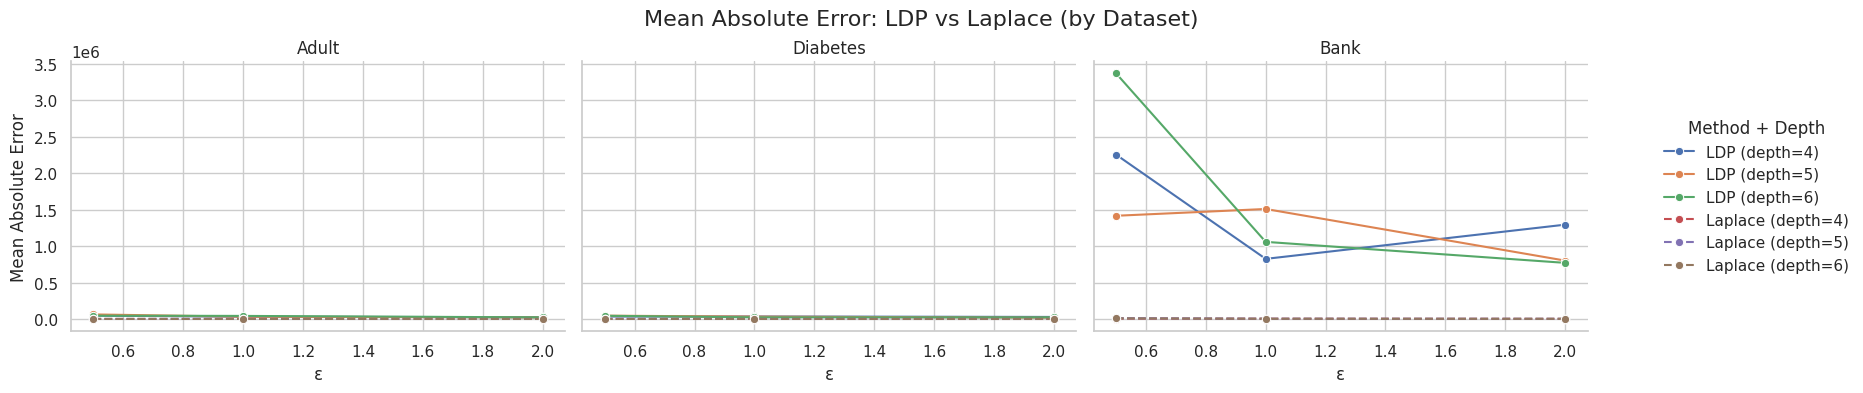

In [ ]:
plot_kaggle_comparison_clean(results_df)

# Ablation Experiment

Basic Experiment

In [ ]:
# Common setup
def generate_synthetic_data(n, value_range=(0, 100)):
    return np.random.randint(value_range[0], value_range[1]+1, size=n)

In [ ]:
# Original Method (Placeholder: tree-based LDP estimation)
def dummy_tree_based_ldp(x, epsilon, value_range=(0, 100)):
    """
    Placeholder function simulating the original tree-encoded LDP estimation.
    This mimics a slightly improved version of the naive approach.
    """
    U = value_range[1] + 1
    max_x = np.max(x)
    noise = np.random.laplace(loc=0, scale=max_x/epsilon, size=1)
    return np.sum(x) + noise[0]

In [ ]:
# Baseline: No tree encoding
def randomized_response_no_encoding(x, epsilon, value_range=(0, 100)):
    U = value_range[1] + 1
    p = np.exp(epsilon) / (np.exp(epsilon) + U - 1)
    q = 1 / (np.exp(epsilon) + U - 1)
    alt_probs = np.full(U, q)

    results = []
    for val in x:
        if np.random.rand() < p:
            results.append(val)
        else:
            results.append(np.random.choice(U, p=alt_probs / alt_probs.sum()))

    est_hist = np.zeros(U)
    for val in results:
        est_hist[val] += 1

    est_hist = (est_hist - len(x) * q) / (p - q)
    est_hist = np.clip(est_hist, 0, None)
    estimated_sum = np.sum([i * est_hist[i] for i in range(U)])
    return estimated_sum

In [ ]:
# Clipping + Tree-based method
def clipped_tree_based_ldp(x, epsilon, clip_bound=50):
    x_clipped = np.clip(x, 0, clip_bound)
    noise = np.random.laplace(loc=0, scale=clip_bound/epsilon, size=1)
    return np.sum(x_clipped) + noise[0]

In [ ]:
# Run Ablation and Clipping Study
def clipped_tree_based_ldp(x, epsilon, clip_bound=50):
    x_clipped = np.clip(x, 0, clip_bound)
    noise = np.random.laplace(loc=0, scale=clip_bound/epsilon, size=1)
    return np.sum(x_clipped) + noise[0]

In [ ]:
# Run Ablation and Clipping Study
def run_ablation_and_clipping_study():
    n = 1000
    value_range = (0, 100)
    epsilons = [0.5, 1.0, 2.0]
    trials = 10

    true_data = generate_synthetic_data(n, value_range)
    true_sum = np.sum(true_data)

    mae_original = []
    mae_ablation = []
    mae_clipping = []

    for eps in epsilons:
        errors_orig = []
        errors_abla = []
        errors_clip = []

        for _ in range(trials):
            est_orig = dummy_tree_based_ldp(true_data, eps, value_range)
            est_abla = randomized_response_no_encoding(true_data, eps, value_range)
            est_clip = clipped_tree_based_ldp(true_data, eps, clip_bound=50)

            errors_orig.append(abs(est_orig - true_sum))
            errors_abla.append(abs(est_abla - true_sum))
            errors_clip.append(abs(est_clip - true_sum))

        mae_original.append(np.mean(errors_orig))
        mae_ablation.append(np.mean(errors_abla))
        mae_clipping.append(np.mean(errors_clip))

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, mae_original, marker='o', label='Original (Tree Encoded)')
    plt.plot(epsilons, mae_ablation, marker='s', label='Ablation (No Tree)')
    plt.plot(epsilons, mae_clipping, marker='^', label='Clipping + Tree')
    plt.xlabel("Privacy Budget (ε)")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title("Ablation vs Clipping in LDP Sum Estimation")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

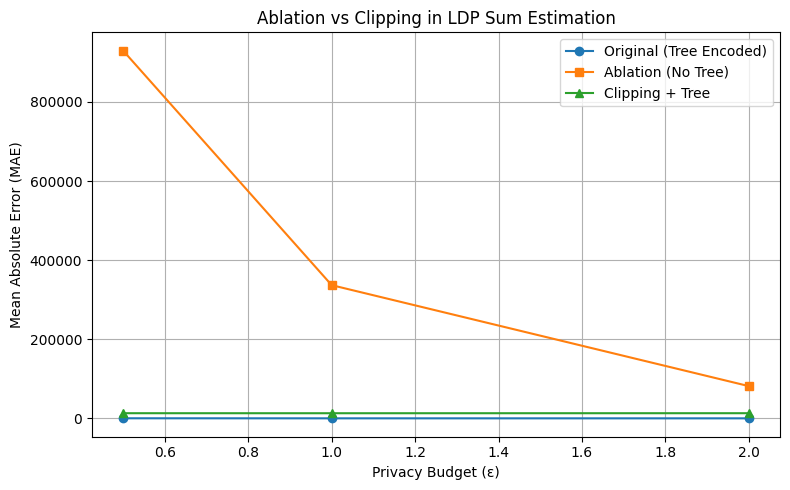

In [ ]:
# Execute the experiment and plot results
run_ablation_and_clipping_study()

Experiment on different data distribution

In [ ]:
# distributions
def generate_uniform_data(n):
    return np.random.randint(0, 101, size=n)

def generate_normal_data(n):
    return np.clip(np.random.normal(loc=50, scale=10, size=n), 0, 100).astype(int)

def generate_pareto_data(n):
    return np.clip((np.random.pareto(a=3, size=n) + 1) * 10, 0, 100).astype(int)

In [ ]:
# LDP
def dummy_tree_ldp(x, epsilon, clip_bound=None):
    if clip_bound is not None:
        x = np.clip(x, 0, clip_bound)
        scale = clip_bound
    else:
        scale = np.max(x)
    noise = np.random.laplace(loc=0, scale=scale/epsilon, size=1)
    return np.sum(x) + noise[0]


In [ ]:
def evaluate_distribution(generator, distribution_name, epsilons=[0.5, 1.0, 2.0], trials=10, clip_bound=50):
    results = []
    for eps in epsilons:
        mae_original, mae_clipped = [], []
        for _ in range(trials):
            data = generator(1000)
            true_sum = np.sum(data)
            est_orig = dummy_tree_ldp(data, eps)
            est_clip = dummy_tree_ldp(data, eps, clip_bound=clip_bound)
            mae_original.append(abs(est_orig - true_sum))
            mae_clipped.append(abs(est_clip - true_sum))
        results.extend([
            {"epsilon": eps, "method": "original", "mae": np.mean(mae_original), "distribution": distribution_name},
            {"epsilon": eps, "method": "clipped", "mae": np.mean(mae_clipped), "distribution": distribution_name},
        ])
    return pd.DataFrame(results)

In [ ]:
# execute experiment
df_uniform = evaluate_distribution(generate_uniform_data, "Uniform")
df_normal = evaluate_distribution(generate_normal_data, "Normal")
df_pareto = evaluate_distribution(generate_pareto_data, "Pareto")
df_all = pd.concat([df_uniform, df_normal, df_pareto])

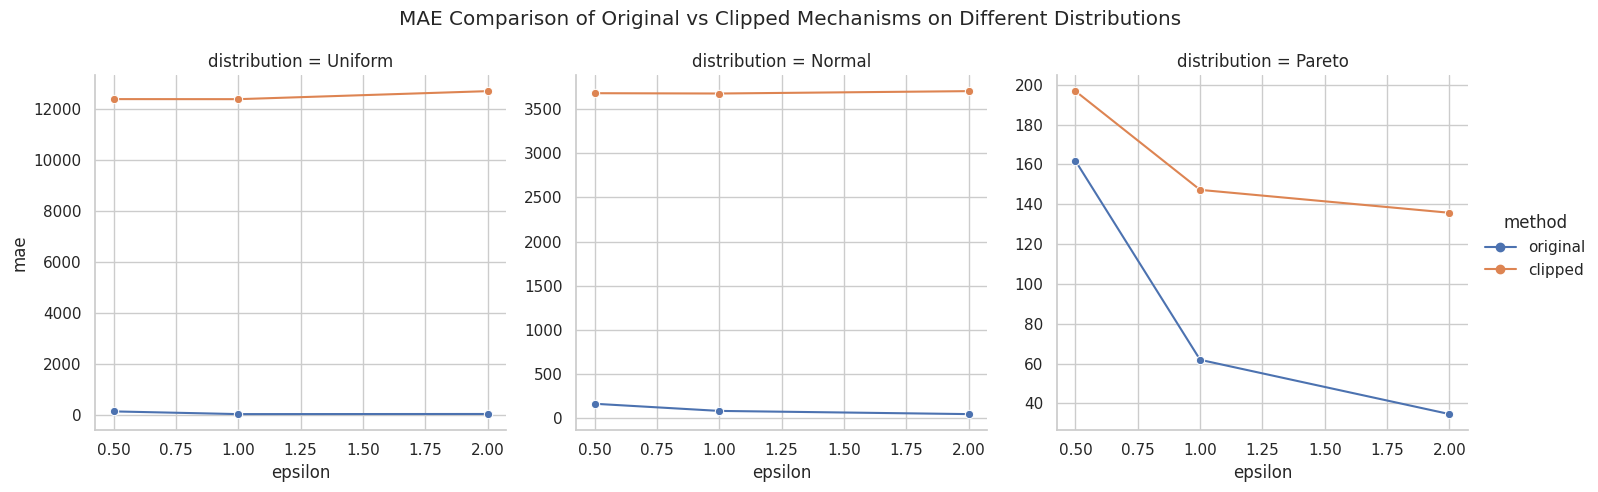

In [ ]:
sns.set(style="whitegrid")
g = sns.relplot(
    data=df_all, x="epsilon", y="mae", hue="method",
    col="distribution", kind="line", marker="o", facet_kws={"sharey": False}
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("MAE Comparison of Original vs Clipped Mechanisms on Different Distributions")
plt.show()

In [ ]:
# Core LDP mechanism
def ldp_sum_estimation(data, epsilon, clip_bound=None, ablation=False):
    if clip_bound is not None:
        data = np.clip(data, 0, clip_bound)
        scale = clip_bound
    else:
        scale = np.max(data)
    if ablation:
        # Randomized response w/o encoding
        U = int(scale + 1)
        p = np.exp(epsilon) / (np.exp(epsilon) + U - 1)
        q = 1 / (np.exp(epsilon) + U - 1)
        noisy_vals = []
        for val in data:
            if np.random.rand() < p:
                noisy_vals.append(val)
            else:
                # Ensure val is an integer for indexing
                noisy_vals.append(np.random.choice(range(U)))
        est_hist = np.zeros(U)
        for val in noisy_vals:
            # Convert val to integer for indexing if it's not already
            est_hist[int(val)] += 1
        est_hist = (est_hist - len(data) * q) / (p - q)
        est_hist = np.clip(est_hist, 0, None)
        return np.sum([i * est_hist[i] for i in range(U)])
    else:
        # Tree-like encoding = Lap noise with adaptive scale
        noise = np.random.laplace(loc=0, scale=scale/epsilon)
        return np.sum(data) + noise

In [ ]:
# Evaluation Runner
def run_ablation_experiment(data, dataset_name, epsilon_list=[0.5, 1.0, 2.0], clip_bound=None, trials=10):
    results = []
    true_sum = np.sum(data)

    for eps in epsilon_list:
        for method in ['original', 'clipped', 'ablation']:
            errors = []
            for _ in range(trials):
                if method == 'original':
                    est = ldp_sum_estimation(data, eps)
                elif method == 'clipped':
                    est = ldp_sum_estimation(data, eps, clip_bound=clip_bound)
                elif method == 'ablation':
                    est = ldp_sum_estimation(data, eps, ablation=True)
                errors.append(abs(est - true_sum))
            results.append({
                "epsilon": eps,
                "mae": np.mean(errors),
                "dataset": dataset_name,
                "method": method
            })
    return pd.DataFrame(results)

In [ ]:
def load_adult_column(path):  # "hours.per.week"
    df = pd.read_csv(path)
    return df["hours.per.week"].dropna().astype(int).values

def load_bank_column(path):  # "duration"
    df = pd.read_csv(path)
    return df["duration"].dropna().astype(int).values

def load_diabetes_column(path):  # "BMI"
    df = pd.read_csv(path)
    return df["BMI"].dropna().astype(float).values

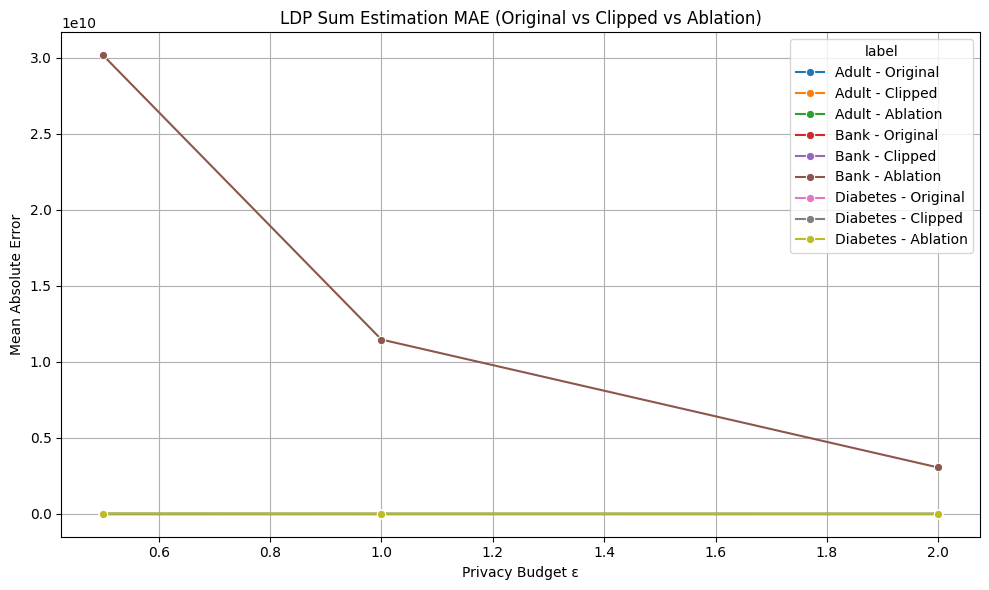

In [ ]:
# main execution
adult_data = load_adult_column("/content/drive/MyDrive/adult.csv")
bank_data = load_bank_column("/content/drive/MyDrive/bank.csv")
diabetes_data = load_diabetes_column("/content/drive/MyDrive/diabetes.csv")

df_adult = run_ablation_experiment(
    data=adult_data,
    dataset_name="Adult",
    epsilon_list=[0.5, 1.0, 2.0],
    clip_bound=50,
    trials=20
)

df_bank = run_ablation_experiment(
    data=bank_data,
    dataset_name="Bank",
    epsilon_list=[0.5, 1.0, 2.0],
    clip_bound=1000,
    trials=20
)

df_diabetes = run_ablation_experiment(
    data=diabetes_data,
    dataset_name="Diabetes",
    epsilon_list=[0.5, 1.0, 2.0],
    clip_bound=50,
    trials=20
)

df_all = pd.concat([df_adult, df_bank, df_diabetes])
df_all["label"] = df_all["dataset"] + " - " + df_all["method"].str.capitalize()

# ------- Visualization --------
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all, x="epsilon", y="mae", hue="label", marker="o")
plt.title("LDP Sum Estimation MAE (Original vs Clipped vs Ablation)")
plt.xlabel("Privacy Budget ε")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()

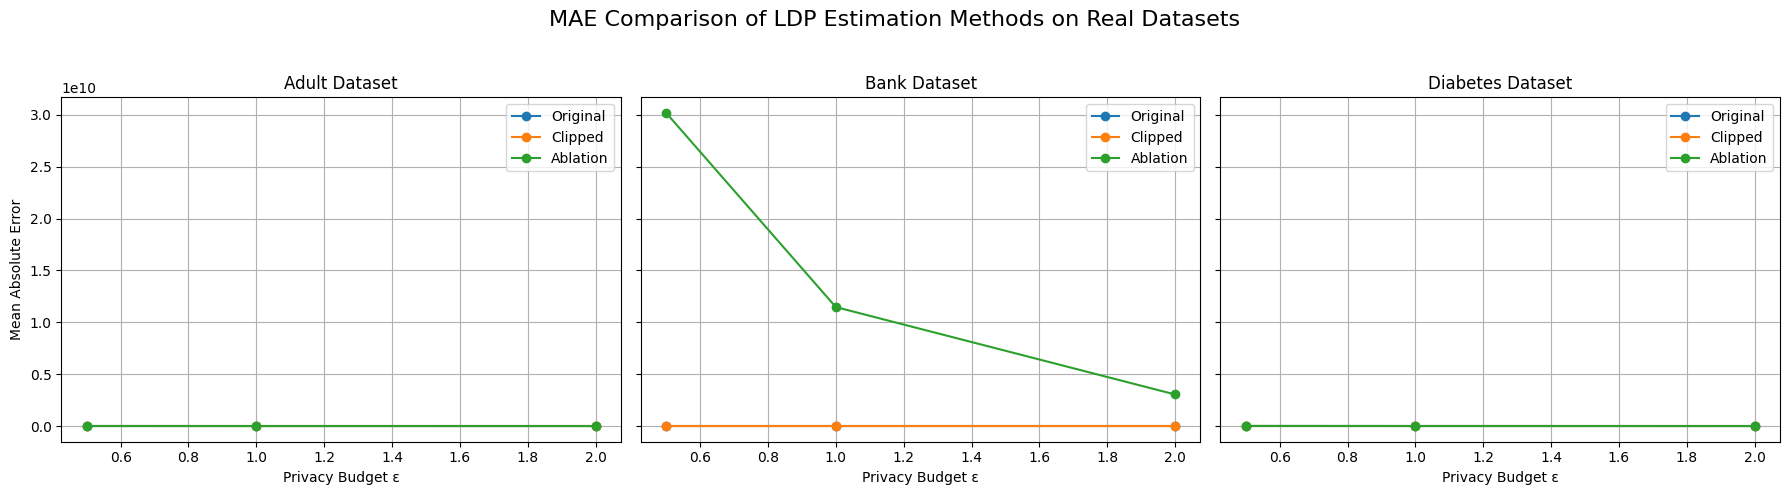

In [ ]:
# 保证数据集顺序排列
datasets = ["Adult", "Bank", "Diabetes"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# 创建横排3个子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    subset = df_all[df_all["dataset"] == dataset]

    for jdx, method in enumerate(["original", "clipped", "ablation"]):
        line_data = subset[subset["method"] == method]
        ax.plot(line_data["epsilon"], line_data["mae"],
                marker='o', label=method.capitalize(), color=colors[jdx])

    ax.set_title(f"{dataset} Dataset")
    ax.set_xlabel("Privacy Budget ε")
    if idx == 0:
        ax.set_ylabel("Mean Absolute Error")
    ax.grid(True)
    ax.legend()

plt.suptitle("MAE Comparison of LDP Estimation Methods on Real Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()